In [42]:
import pandas as pd 
import numpy as np 
from loguru import logger 
from matplotlib import pyplot as plt
import rasterio
import os 
import geopandas as gpd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import label
from scipy import ndimage
import cv2
from tqdm import tqdm
from glob import glob
import geopandas as gpd
import os
import rasterio
# from pyproj import Transformer

from rasterio.features import shapes
from shapely.geometry import shape
import utm

import argparse
import warnings
from pathlib import Path

import geopandas as gpd
import rasterio
from shapely.geometry import box
from pyproj import CRS
from rasterio.transform import xy

In [2]:
imgs_dir = "/project/pi_cjgleason_umass_edu/swot_planet/unit/"
ref_df_fp = "/project/pi_cjgleason_umass_edu/swot_planet/yukon_imgs.csv"
ref_df = pd.read_csv(ref_df_fp)

In [3]:
# get corresponding SWORD file from reach_id
sword_mapping_fp = "all_sword_mapping_v16.csv" # SWORDv16
sword_mapping = pd.read_csv(sword_mapping_fp)

In [4]:
fp = "/scratch3/workspace/rdaroya_umass_edu-water/river-width-planet-global/tiled_planet_predicted_merged/81210100041.0--23810af8-d590-44e5-8d82-401a7170e44f--PSScene--20240408_213204_63_24c0_3B_AnalyticMS_SR_clip.tif"
data = rasterio.open(fp).read()
data.shape

(1, 4852, 4537)

In [5]:
reach_id = int(float(os.path.basename(fp).split("--")[0]))
reach_id

81210100041

In [10]:
filtered_sword = sword_mapping[sword_mapping["reach_id"]==reach_id]
assert len(filtered_sword)==1
sword_fp = filtered_sword.iloc[0]["sword_fp"]

In [11]:
sword_fp

'/nas/cee-water/cjgleason/data/SWORD/SWORDv16/shp/NA/na_sword_reaches_hb81_v16.shp'

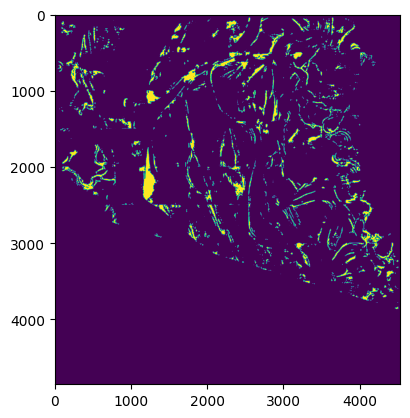

In [7]:
plt.imshow(data[0])

In [22]:

def remove_small_islands(binary_mask, min_size=500):
    labeled_mask, num_features = label(binary_mask)
    
    for i in range(1, num_features + 1):
        if np.sum(labeled_mask == i) < min_size:
            binary_mask[labeled_mask == i] = 0
    
    return binary_mask



### Get regions that intersect with SWORD reach
def get_sword_mask_intersection(raster_path, sword_gdf, tile_fp, satellite_src):
    # Load the binary mask raster
    if satellite_src == "planet-baseline":
        with rasterio.open(raster_path) as src1:
            binary_mask = src1.read(1)
        with rasterio.open(tile_fp) as src: # use input tile as source of transforms, etc
            transform = src.transform
            raster_crs = src.crs
            extent = src.bounds
    
    else:
        with rasterio.open(raster_path) as src:
            binary_mask = src.read(1)
            transform = src.transform
            raster_crs = src.crs
            extent = src.bounds


    # Ensure the line shapefile has the same CRS as the raster
    if sword_gdf.crs != raster_crs:
        sword_gdf = sword_gdf.to_crs(raster_crs)

    # Identify contiguous regions in the binary mask
    mask_labels, num_labels = ndimage.label(binary_mask)

    # Convert labeled mask regions to polygons
    shapes_list = list(shapes(mask_labels, transform=transform))  # Store generator results

    region_polygons = [shape(geom) for geom, value in shapes_list if value > 0]
    region_ids = [value for _, value in shapes_list if value > 0]  # Extract region IDs correctly

    # Create a GeoDataFrame of regions
    gdf_regions = gpd.GeoDataFrame({'region_id': region_ids, 'geometry': region_polygons}, crs=raster_crs)

    # Find intersecting regions
    intersecting_regions = gdf_regions[gdf_regions.intersects(sword_gdf.unary_union)]
    intersecting_region_ids = intersecting_regions['region_id'].tolist()
    intersecting_mask = np.isin(mask_labels, intersecting_region_ids)
    
    return binary_mask, intersecting_mask


In [ ]:


# --------------------------------------------------------------------------- #
# helpers
# --------------------------------------------------------------------------- #
def crs_is_projected(crs: CRS) -> bool:
    """Return True if the CRS' units are linear (projected)."""
    return CRS(crs).is_projected

def choose_metric_crs(raster_crs: CRS, bounds) -> CRS:
    """
    Pick a metric CRS for accurate length measurement.

    1.  If the raster CRS is already projected → use it.
    2.  Otherwise, build a suitable UTM zone based on the raster centre.
    """
    if crs_is_projected(raster_crs):
        return raster_crs

    # derive UTM zone from the raster centre (lon,lat)
    lon_c = (bounds.left + bounds.right) / 2
    lat_c = (bounds.top + bounds.bottom) / 2
    zone_number = int((lon_c + 180) // 6) + 1
    hemi = "north" if lat_c >= 0 else "south"
    utm_crs = CRS.from_dict(
        {"proj": "utm", "zone": zone_number, "south": hemi == "south", "ellps": "WGS84"}
    )
    return utm_crs

def choose_metric_crs_nonzero_bounds(rast_crs: CRS, bounds) -> CRS:
    """
    Pick a metric CRS for accurate length measurement.

    1.  If the raster CRS is already projected → use it.
    2.  Else build an on-the-fly UTM zone centred on `bounds`.
    """
    if crs_is_projected(rast_crs):
        return rast_crs

    lon_c = (bounds[0] + bounds[2]) / 2          # minx, miny, maxx, maxy
    lat_c = (bounds[1] + bounds[3]) / 2
    zone = int((lon_c + 180) // 6) + 1
    hemi = "south" if lat_c < 0 else "north"
    return CRS.from_dict({"proj": "utm",
                          "zone": zone,
                          "south": hemi == "south",
                          "ellps": "WGS84"})


def nonzero_bounds(dataset, masked_data):
    """
    Return (minx, miny, maxx, maxy) of the raster area where values ≠ 0 / nodata.
    If *all* cells are 0 / nodata, raises a RuntimeError.
    """
    # arr = dataset.read(1, masked=True)           # masked with nodata
    mask = (masked_data != 0)                  # True where value ≠ 0
    if not mask.any():
        raise RuntimeError("Raster contains no non-zero cells.")

    rows, cols = np.nonzero(mask)
    xs, ys = xy(dataset.transform, rows, cols, offset="center")
    xs, ys = np.asarray(xs), np.asarray(ys)
    return xs.min(), ys.min(), xs.max(), ys.max()

def get_intersecting_reach_len_bounded(shp_path: Path, rast_path: Path, reach_id: int, masked_data):
    # 1. open raster & build “non-zero” footprint bounding box
    with rasterio.open(rast_path) as ras:
        rast_crs = ras.crs
        rast_bounds = ras.bounds           # in raster's native CRS
        minx, miny, maxx, maxy = nonzero_bounds(ras, masked_data)
        footprint_poly = box(minx, miny, maxx, maxy)

    # 2. read shapefile and project into raster CRS
    gdf = gpd.read_file(shp_path)
    gdf = gdf[gdf["reach_id"]==reach_id]
    if gdf.empty:
        raise RuntimeError("Shapefile contains no geometries.")
    gdf_rast = gdf.to_crs(rast_crs)

    # 3. clip by the footprint
    clipped = gdf_rast.intersection(footprint_poly)
    clipped = gpd.GeoSeries(clipped[~clipped.is_empty], crs=rast_crs)
    if clipped.empty:
        print(0.0)
        return rast_bounds, rast_crs, 0

    # 4. re-project to a metric CRS and measure length
    metric_crs = choose_metric_crs(rast_crs, (minx, miny, maxx, maxy))
    if metric_crs != rast_crs:
        warnings.warn(
            f"Raster CRS is geographic; using dynamic UTM "
            f"{metric_crs.to_string()} for length calculation.",
            stacklevel=2,
        )

    length_m = clipped.to_crs(metric_crs).length.sum()
    print(round(float(length_m), 3))
    return rast_bounds, rast_crs, length_m

def get_intersecting_reach_len(shp_path: Path, rast_path: Path, reach_id: int):
    # 1. open raster & fetch its bounds/CRS
    with rasterio.open(rast_path) as ras:
        rast_bounds = ras.bounds           # in raster's native CRS
        rast_crs = ras.crs

    # 2. read vector; re-project into raster CRS so we can clip by bounds
    gdf = gpd.read_file(shp_path)
    gdf = gdf[gdf["reach_id"]==reach_id]
    if gdf.empty:
        raise RuntimeError("Shapefile contains no geometries.")

    gdf_in_rast_crs = gdf.to_crs(rast_crs)

    # 3. clip by raster bounding box
    bbox_poly = box(*rast_bounds)
    clipped = gdf_in_rast_crs.intersection(bbox_poly)

    # intersection() returns a GeoSeries; drop empties & wrap back in GeoDataFrame
    clipped = gpd.GeoSeries(clipped[~clipped.is_empty], crs=rast_crs)
    if clipped.empty:
        # print(0.0)
        return rast_bounds, rast_crs, 0

    # 4. choose a metric CRS (either raster's projected CRS, or on-the-fly UTM)
    metric_crs = choose_metric_crs(rast_crs, rast_bounds)
    if metric_crs != rast_crs:
        warnings.warn(
            f"Raster CRS is geographic; using dynamical UTM {metric_crs.to_string()} "
            "for length calculation.",
            stacklevel=2,
        )

    clipped_m = clipped.to_crs(metric_crs)

    # 5. compute & print length in metres
    total_m = clipped_m.length.sum()
    # print(round(float(total_m), 3))
    return rast_bounds, rast_crs, total_m

In [25]:
gdf = gpd.read_file(sword_fp)
sword_gdf = gdf[gdf["reach_id"]==reach_id]

binary_mask, intersecting_mask = get_sword_mask_intersection(raster_path=fp, sword_gdf=sword_gdf, tile_fp=fp, satellite_src="planet")

In [37]:
raster_bounds, raster_crs, bounded_len = get_intersecting_reach_len_bounded(shp_path=sword_fp, rast_path=fp, reach_id=reach_id, masked_data=intersecting_mask)

4145.436


ERROR 1: PROJ: internal_proj_identify: /home/rdaroya_umass_edu/miniconda3/envs/ann-ssc/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/rdaroya_umass_edu/miniconda3/envs/ann-ssc/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [ ]:
raster_bounds

In [ ]:
sword_gdf_raster = sword_gdf.to_crs(raster_crs)

<Axes: >

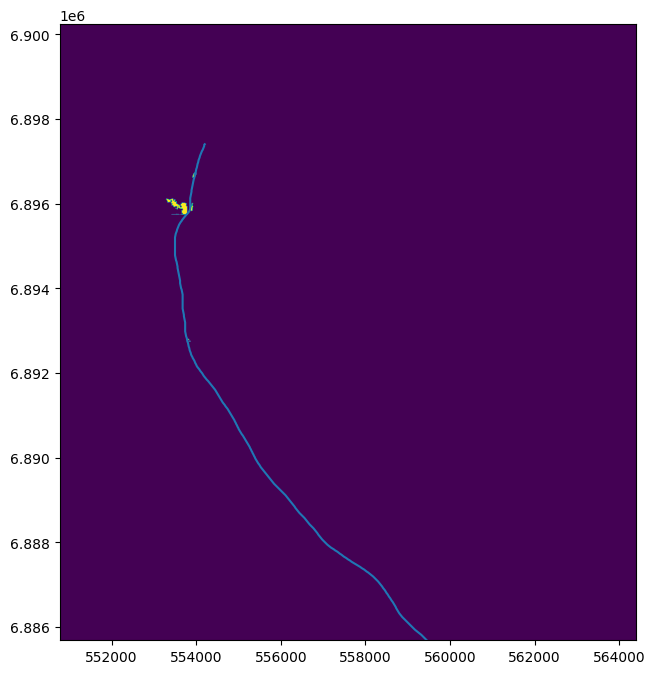

In [39]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
ax1.imshow(intersecting_mask, extent=[raster_bounds.left, raster_bounds.right,raster_bounds.bottom, raster_bounds.top])
ax1.set_xlim(raster_bounds.left, raster_bounds.right)
ax1.set_ylim(raster_bounds.bottom, raster_bounds.top)
# plt.imshow()
sword_gdf_raster.plot(ax=ax1)

In [21]:
get_intersecting_reach_len(shp_path=sword_fp, rast_path=fp, reach_id=reach_id)

ERROR 1: PROJ: internal_proj_identify: /home/rdaroya_umass_edu/miniconda3/envs/ann-ssc/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/rdaroya_umass_edu/miniconda3/envs/ann-ssc/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


14063.899884658267

9087

In [19]:
16599.78875-14063.9

2535.88875

In [15]:
sword_data = gpd.read_file(sword_fp)
sword_data[sword_data["reach_id"]==reach_id]

,x,y,reach_id,reach_len,n_nodes,wse,wse_var,width,width_var,facc,...,n_rch_dn,rch_id_up,rch_id_dn,swot_orbit,swot_obs,type,river_name,edit_flag,trib_flag,geometry
1434,-163.92245,62.141392,81210100041,16599.78875,83,4.9,0.032227,1887.0,443733.481941,830155.125,...,1,81210100051,81210100235,26 43 332 349,4,1,Yukon River,NaN,0,"LINESTRING (-163.95779 62.20470, -163.95837 62..."


In [60]:
ref_df

,reach_id,time_swot,time_planet,planet_cloud_cover,planet_dir
0,8.129290e+10,2024-04-30 05:33:49+00:00,2024-04-29 20:38:12+00:00,0.00,/project/pi_cjgleason_umass_edu/swot_planet/un...
1,8.129290e+10,2024-04-29 05:33:17+00:00,2024-04-28 19:47:52+00:00,0.00,/project/pi_cjgleason_umass_edu/swot_planet/un...
2,8.129290e+10,2024-06-10 23:04:00+00:00,2024-06-10 20:41:01+00:00,0.00,/project/pi_cjgleason_umass_edu/swot_planet/un...
3,8.129290e+10,2024-04-29 05:33:17+00:00,2024-04-28 19:47:25+00:00,0.09,/project/pi_cjgleason_umass_edu/swot_planet/un...
4,8.129290e+10,2024-08-01 14:56:23+00:00,2024-08-01 20:39:22+00:00,0.26,/project/pi_cjgleason_umass_edu/swot_planet/un...
...,...,...,...,...,...
12216,8.129900e+10,2024-04-15 22:19:27+00:00,2024-04-15 19:17:43+00:00,0.00,/project/pi_cjgleason_umass_edu/swot_planet/un...
12217,8.129900e+10,2024-06-07 23:02:54+00:00,2024-06-07 20:11:38+00:00,0.00,/project/pi_cjgleason_umass_edu/swot_planet/un...
12218,8.129900e+10,2024-04-14 22:18:46+00:00,2024-04-14 19:16:01+00:00,0.62,/project/pi_cjgleason_umass_edu/swot_planet/un...
12219,8.129900e+10,2024-04-14 22:18:46+00:00,2024-04-14 19:12:39+00:00,0.51,/project/pi_cjgleason_umass_edu/swot_planet/un...


In [51]:
ref_df["planet_dir"].iloc[0]

'/project/pi_cjgleason_umass_edu/swot_planet/unit/81292900261.0/a280e34e-268f-41d4-85e8-773c7b38b9c9/PSScene/20240429_203812_47_24f1_3B_AnalyticMS_SR_clip.tif'